# Visual Outlier Detection Methods
(copilot generated, not used)
Common approaches bioinformaticians use to identify outliers:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('../data/merged.csv')
df["Thal (n)"] = df["Thal"].str.split(" ").str[1].astype(int)

df["ABeta ratio"] = df["ABeta42 pg/ug"] / df["ABeta40 pg/ug"]
df["TAU ratio"] = df["pTAU pg/ug"] / df["tTAU pg/ug"]
education_order = [
    "High School",
    "Trade School/ Tech School",
    "Bachelors",
    "Graduate (PhD/Masters)",
    "Professional",
]
df["Highest level of education"] = pd.Categorical(
    df["Highest level of education"], categories=education_order, ordered=True
)
# condense into 2 groups, high school and post-secondary
df["Post-secondary"] = pd.Categorical(
    df["Highest level of education"].apply(
        lambda x: "High School" if x == "High School" else "Post-Secondary"
    ),
    categories=["High School", "Post-Secondary"],
    ordered=True,
)
# condense into 2 groups, e4+ and e4-
df["APOE Genotype 4"] = df["APOE Genotype"].apply(
    lambda x: "e4+" if "4" in x else "e4-"
)
print(f"Dataset shape: {df.shape}")

Dataset shape: (84, 75)


## 1. Box Plots - Best for Single Variables
Quickly shows quartiles, median, and outliers (points beyond 1.5×IQR)

Axes(0.125,0.53;0.227941x0.35)
Axes(0.398529,0.53;0.227941x0.35)
Axes(0.672059,0.53;0.227941x0.35)
Axes(0.125,0.11;0.227941x0.35)
Axes(0.398529,0.11;0.227941x0.35)
Axes(0.672059,0.11;0.227941x0.35)


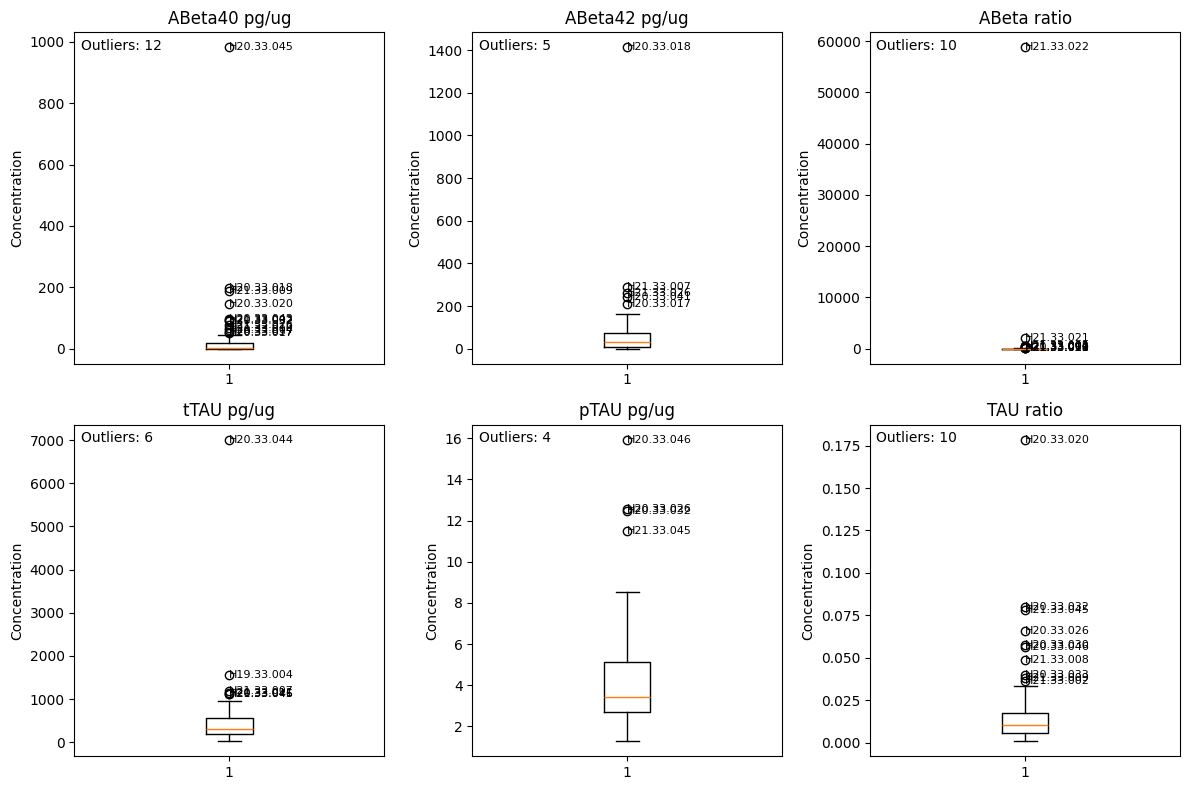

In [2]:
# Box plots for all biomarkers
biomarkers = ["ABeta40 pg/ug", "ABeta42 pg/ug", "ABeta ratio", "tTAU pg/ug", "pTAU pg/ug", "TAU ratio"]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, biomarker in enumerate(biomarkers):
    if biomarker in df.columns:
        axes[i].boxplot(df[biomarker].dropna())
        print(axes[i])
        axes[i].set_title(biomarker)
        axes[i].set_ylabel("Concentration")

        # Add outlier count
        Q1, Q3 = df[biomarker].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = df[
            (df[biomarker] < Q1 - 1.5 * IQR) | (df[biomarker] > Q3 + 1.5 * IQR)
        ]
        axes[i].text(
            0.02,
            0.98,
            f"Outliers: {len(outliers)}",
            transform=axes[i].transAxes,
            verticalalignment="top",
        )

plt.tight_layout()
# annotate with subject id
for i, biomarker in enumerate(biomarkers):
    if biomarker in df.columns:
        Q1, Q3 = df[biomarker].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = df[
            (df[biomarker] < Q1 - 1.5 * IQR) | (df[biomarker] > Q3 + 1.5 * IQR)
        ]
        for _, row in outliers.iterrows():
            axes[i].text(
                1,
                row[biomarker],
                str(row["Donor ID"]),
                fontsize=8,
                verticalalignment="center",
                horizontalalignment="left",
            )
plt.show()

## 2. Histograms - Show Distribution Shape
Reveals skewness, multiple modes, and extreme values

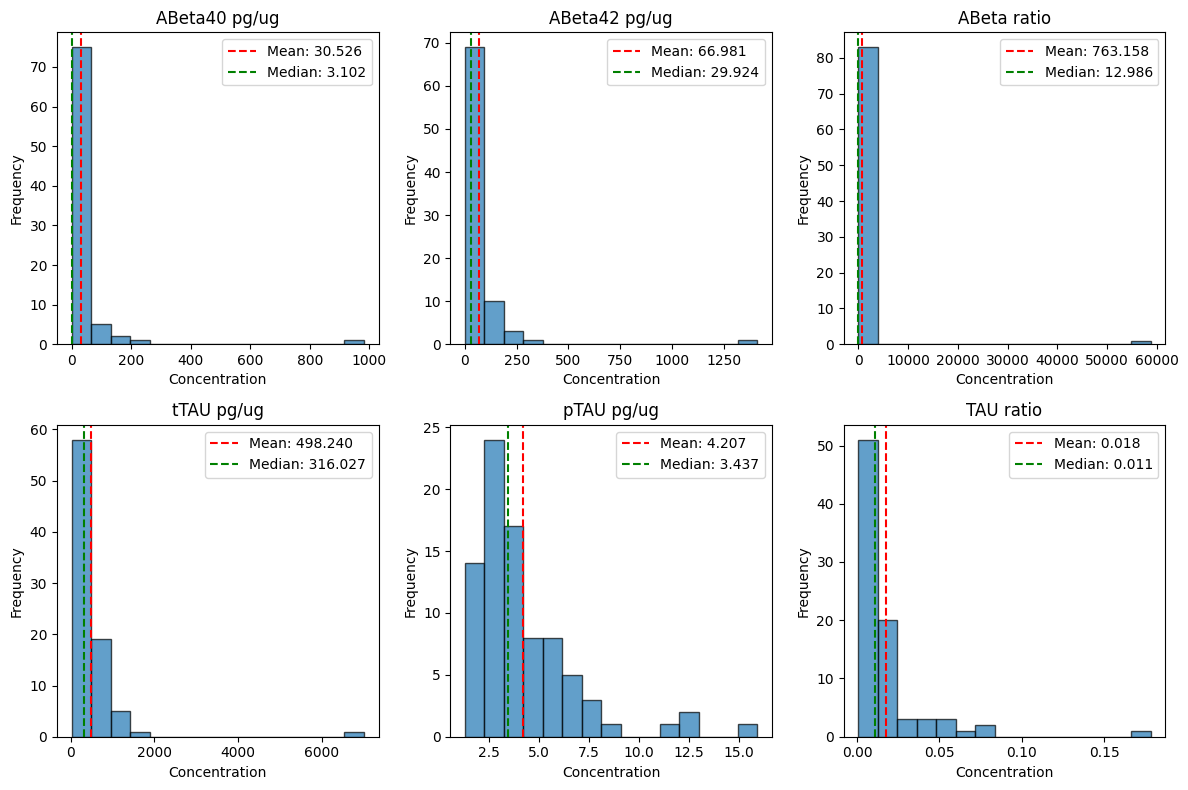

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, biomarker in enumerate(biomarkers):
    if biomarker in df.columns:
        data = df[biomarker].dropna()
        axes[i].hist(data, bins=15, alpha=0.7, edgecolor='black')
        axes[i].set_title(biomarker)
        axes[i].set_xlabel('Concentration')
        axes[i].set_ylabel('Frequency')
        
        # Add mean and median lines
        axes[i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
        axes[i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.3f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

## 3. Scatter Plots - Find Multivariate Outliers
Shows relationships between variables and points that don't fit patterns

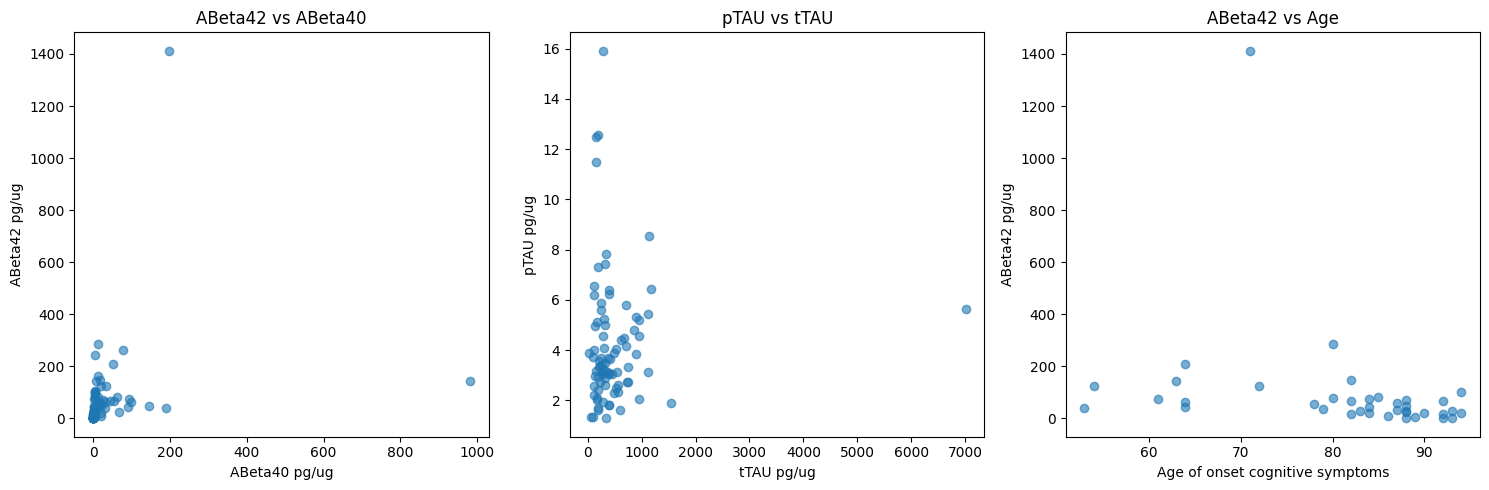

In [45]:
# Key biomarker relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Aβ42 vs Aβ40 (important ratio)
if "ABeta42 pg/ug" in df.columns and "ABeta40 pg/ug" in df.columns:
    axes[0].scatter(df["ABeta40 pg/ug"], df["ABeta42 pg/ug"], alpha=0.6)
    axes[0].set_xlabel("ABeta40 pg/ug")
    axes[0].set_ylabel("ABeta42 pg/ug")
    axes[0].set_title("ABeta42 vs ABeta40")

# TAU vs pTAU
if "tTAU pg/ug" in df.columns and "pTAU pg/ug" in df.columns:
    axes[1].scatter(df["tTAU pg/ug"], df["pTAU pg/ug"], alpha=0.6)
    axes[1].set_xlabel("tTAU pg/ug")
    axes[1].set_ylabel("pTAU pg/ug")
    axes[1].set_title("pTAU vs tTAU")

# Age vs a biomarker
if "Age of onset cognitive symptoms" in df.columns and "ABeta42 pg/ug" in df.columns:
    axes[2].scatter(
        df["Age of onset cognitive symptoms"], df["ABeta42 pg/ug"], alpha=0.6
    )
    axes[2].set_xlabel("Age of onset cognitive symptoms")
    axes[2].set_ylabel("ABeta42 pg/ug")
    axes[2].set_title("ABeta42 vs Age")

plt.tight_layout()
plt.show()

## 4. Z-Score Analysis - Standardized Outliers
Shows how many standard deviations each point is from the mean

In [46]:
# Calculate Z-scores for biomarkers
from scipy import stats

outlier_summary = []

for biomarker in biomarkers:
    if biomarker in df.columns:
        data = df[biomarker].dropna()
        z_scores = np.abs(stats.zscore(data))
        
        # Count outliers at different thresholds
        outliers_2std = sum(z_scores > 2)
        outliers_3std = sum(z_scores > 3)
        
        outlier_summary.append({
            'Biomarker': biomarker,
            'N': len(data),
            'Outliers (|z|>2)': outliers_2std,
            'Outliers (|z|>3)': outliers_3std,
            'Max |z|': z_scores.max()
        })

outlier_df = pd.DataFrame(outlier_summary)
print("Outlier Summary by Z-Score:")
display(outlier_df)

Outlier Summary by Z-Score:


,Biomarker,N,Outliers (|z|>2),Outliers (|z|>3),Max |z|
0,ABeta40 pg/ug,84,1,1,8.560769
1,ABeta42 pg/ug,84,1,1,8.433586
2,ABeta ratio,84,1,1,9.103601
3,tTAU pg/ug,84,1,1,8.371045
4,pTAU pg/ug,84,4,3,4.551456
5,TAU ratio,84,4,1,6.731928


## 5. Correlation Heatmap - Find Unusual Patterns
Identifies samples that don't follow expected biomarker correlations

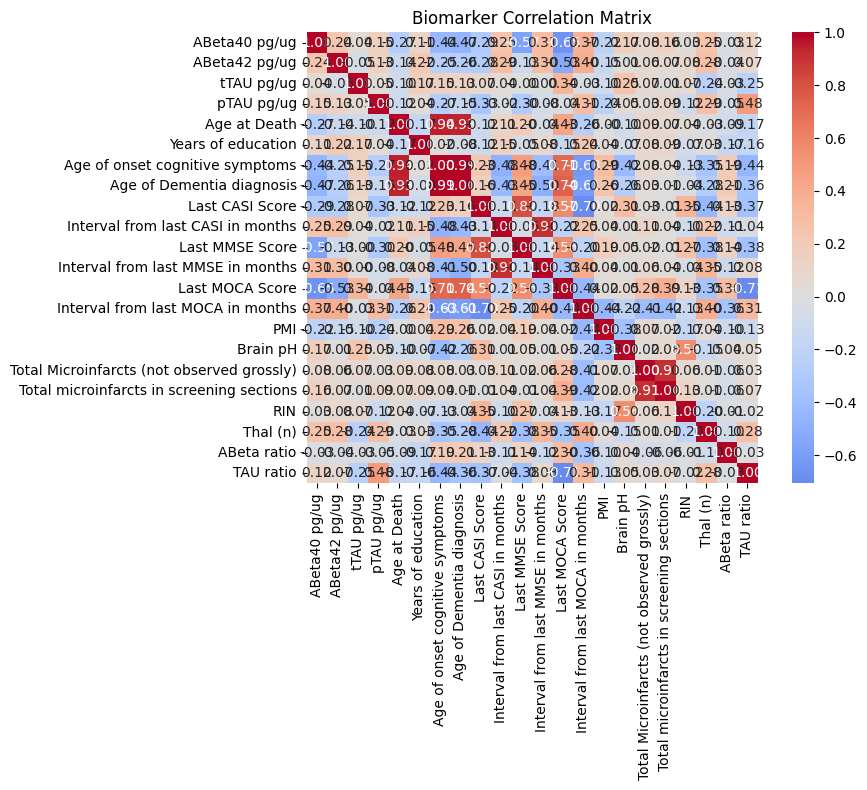

In [47]:
# Correlation matrix of biomarkers
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Biomarker Correlation Matrix')
plt.tight_layout()
plt.show()

## 6. Sample-Level Outlier Check
Identify specific samples that are outliers across multiple biomarkers

In [48]:
# Find samples that are outliers in multiple biomarkers
outlier_samples = []

for idx, row in df.iterrows():
    outlier_count = 0
    outlier_biomarkers = []
    
    for biomarker in biomarkers:
        if biomarker in df.columns and pd.notna(row[biomarker]):
            # Use IQR method
            Q1, Q3 = df[biomarker].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            
            if row[biomarker] < lower or row[biomarker] > upper:
                outlier_count += 1
                outlier_biomarkers.append(biomarker)
    
    if outlier_count >= 2:  # Outlier in 2+ biomarkers
        outlier_samples.append({
            'Sample_ID': row.get('Donor ID', idx),
            'Outlier_Count': outlier_count,
            'Outlier_Biomarkers': ', '.join(outlier_biomarkers)
        })

if outlier_samples:
    outlier_samples_df = pd.DataFrame(outlier_samples)
    print(f"Samples that are outliers in 2+ biomarkers: {len(outlier_samples)}")
    display(outlier_samples_df)
else:
    print("No samples are outliers in multiple biomarkers")

Samples that are outliers in 2+ biomarkers: 12


,Sample_ID,Outlier_Count,Outlier_Biomarkers
0,H20.33.045,2,"ABeta40 pg/ug, tTAU pg/ug"
1,H21.33.045,2,"pTAU pg/ug, TAU ratio"
2,H20.33.046,2,"pTAU pg/ug, TAU ratio"
3,H21.33.007,2,"ABeta42 pg/ug, tTAU pg/ug"
4,H20.33.017,2,"ABeta40 pg/ug, ABeta42 pg/ug"
5,H20.33.018,2,"ABeta40 pg/ug, ABeta42 pg/ug"
6,H20.33.026,2,"pTAU pg/ug, TAU ratio"
7,H20.33.020,2,"ABeta40 pg/ug, TAU ratio"
8,H20.33.032,3,"ABeta40 pg/ug, pTAU pg/ug, TAU ratio"
9,H21.33.009,2,"ABeta40 pg/ug, TAU ratio"


## Summary: Best Practices for Outlier Detection

1. **Start with box plots** - quickest overview
2. **Use scatter plots** - check biological relationships make sense
3. **Look at histograms** - understand your data distribution
4. **Z-score analysis** - quantify how extreme outliers are
5. **Sample-level analysis** - identify problematic samples

**Remember**: Only remove outliers you can justify biologically or as clear measurement errors!